In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

/var/folders/cn/qh1c0kgs1y7bqdlpqd82cpqc0000gn/T/ipykernel_44558/1099191483.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [21]:
procs_added = pd.read_csv("procs_added.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "actualComp"])
procs_current = pd.read_csv("procs_current.txt", index_col=None, names=["tick", "machineID", "sla", "actualComp", "compDone"])
procs_done = pd.read_csv("procs_done.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "ticksPassed", "actualComp"])
procs_killed = pd.read_csv("procs_killed.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "memUsed"])

# To find problem times/areas

## Procs late

### Overall

In [8]:
procs_late = procs_done.where(procs_done["ticksPassed"] > procs_done["sla"]).dropna().reset_index(drop=True)
# I am only looking at true negatives, ie where it would have been possible to finish the proc within the SLA
procs_late = procs_late.where(procs_late["ticksPassed"] > procs_late["actualComp"]).dropna().reset_index(drop=True)
procs_late['amountLate'] = procs_late["ticksPassed"] - procs_late["actualComp"]
procs_late

,tick,machineID,procType,sla,ticksPassed,actualComp,amountLate
0,2.0,0.0,page dynamic,0.892301,0.895611,0.889340,0.006271
1,3.0,0.0,page static,0.136980,0.202991,0.123560,0.079430
2,3.0,1.0,page dynamic,1.108374,1.172078,0.979671,0.192406
3,3.0,1.0,page static,0.190574,0.368995,0.196917,0.172078
4,3.0,3.0,page dynamic,1.169998,1.225146,1.064267,0.160880
...,...,...,...,...,...,...,...
1402,100.0,14.0,data process fg,4.531380,46.061875,2.669279,43.392595
1403,100.0,14.0,page static,0.214085,4.949328,0.164684,4.784644
1404,100.0,18.0,page static,0.497515,12.895892,0.546346,12.349546
1405,100.0,19.0,page dynamic,3.709335,50.605283,2.921106,47.684178


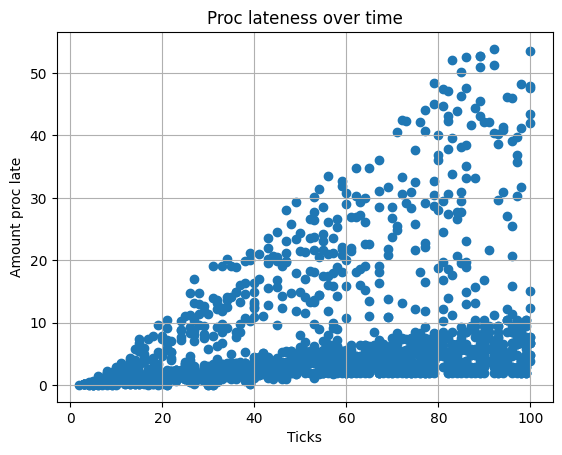

In [26]:
# overall plot
plt.scatter(procs_late["tick"], procs_late['amountLate'].values)
plt.xlabel('Ticks')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over time')
plt.grid(True)
plt.show()

### Per machine

In [ ]:
machine = 3

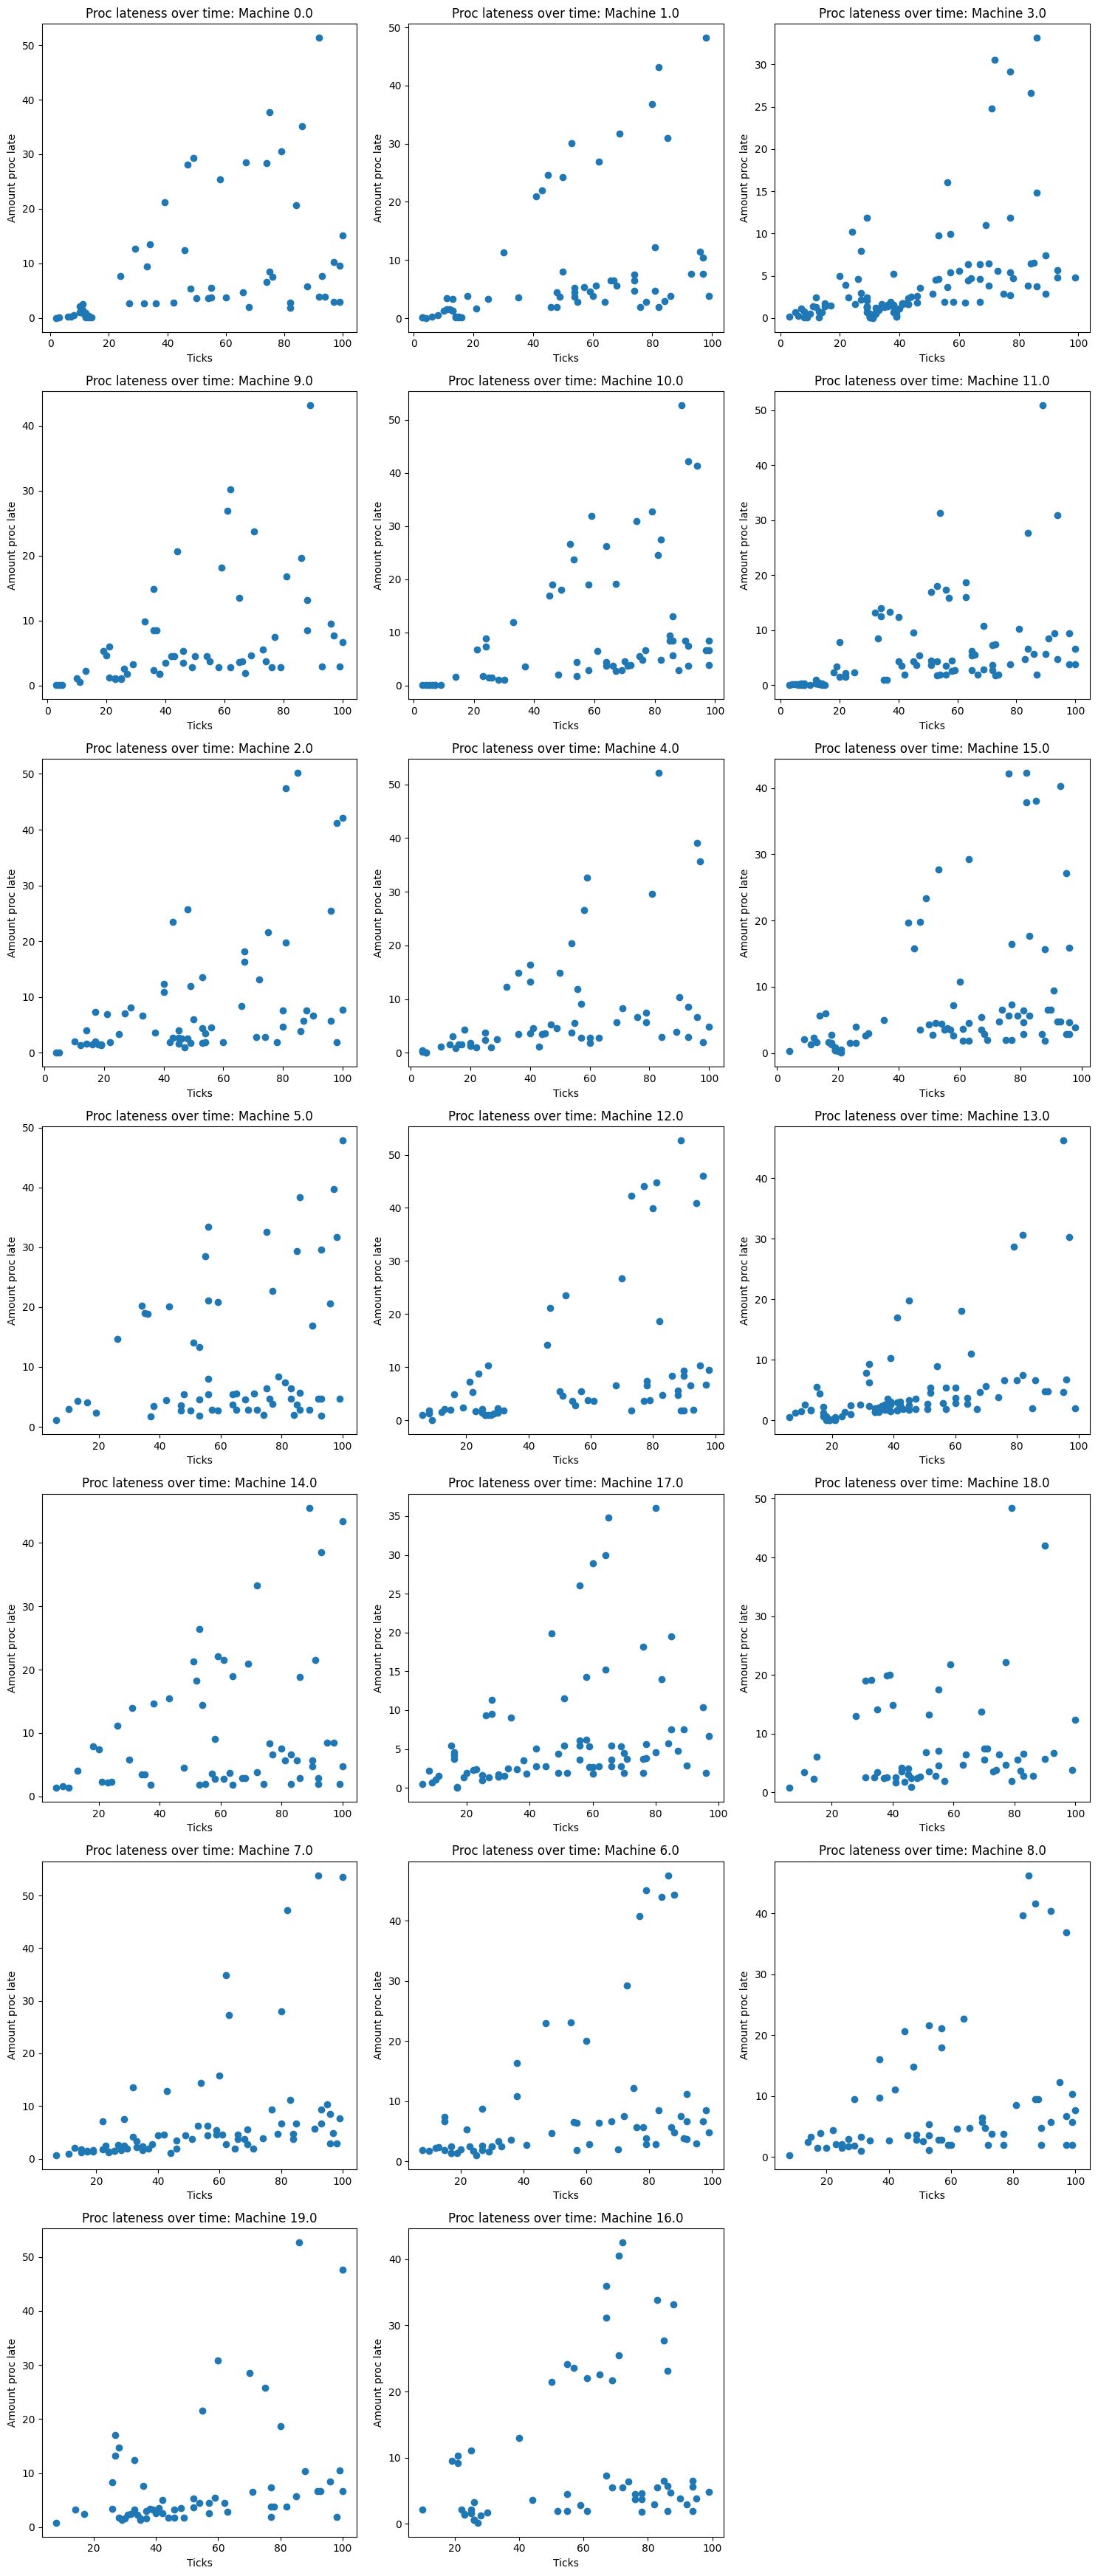

In [31]:
unique_ids = procs_late['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    data = procs_late.where((procs_late['machineID']==id_)).dropna().reset_index(drop=True)
    ax.scatter(data["tick"], data['amountLate'].values)
    ax.set_title(f'Proc lateness over time: Machine {id_}')
    ax.set_xlabel('Ticks')
    ax.set_ylabel('Amount proc late')
    # ax.set_grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Procs killed

### Overall

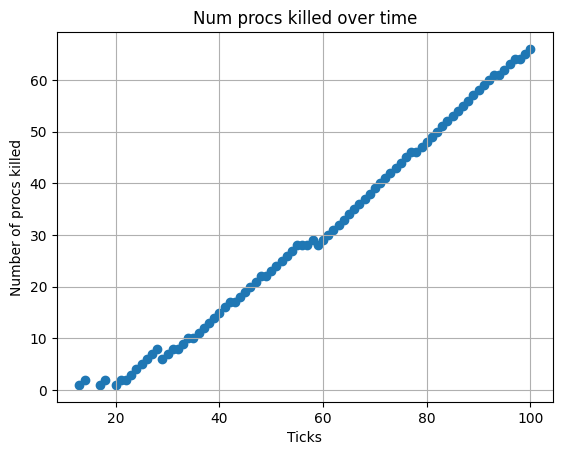

In [25]:
ticks_procs_killed = procs_killed[["tick"]].groupby("tick").size().reset_index(name='counts')
ticks_procs_killed

plt.scatter(ticks_procs_killed["tick"], ticks_procs_killed['counts'].values)
plt.xlabel('Ticks')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

### Per machine

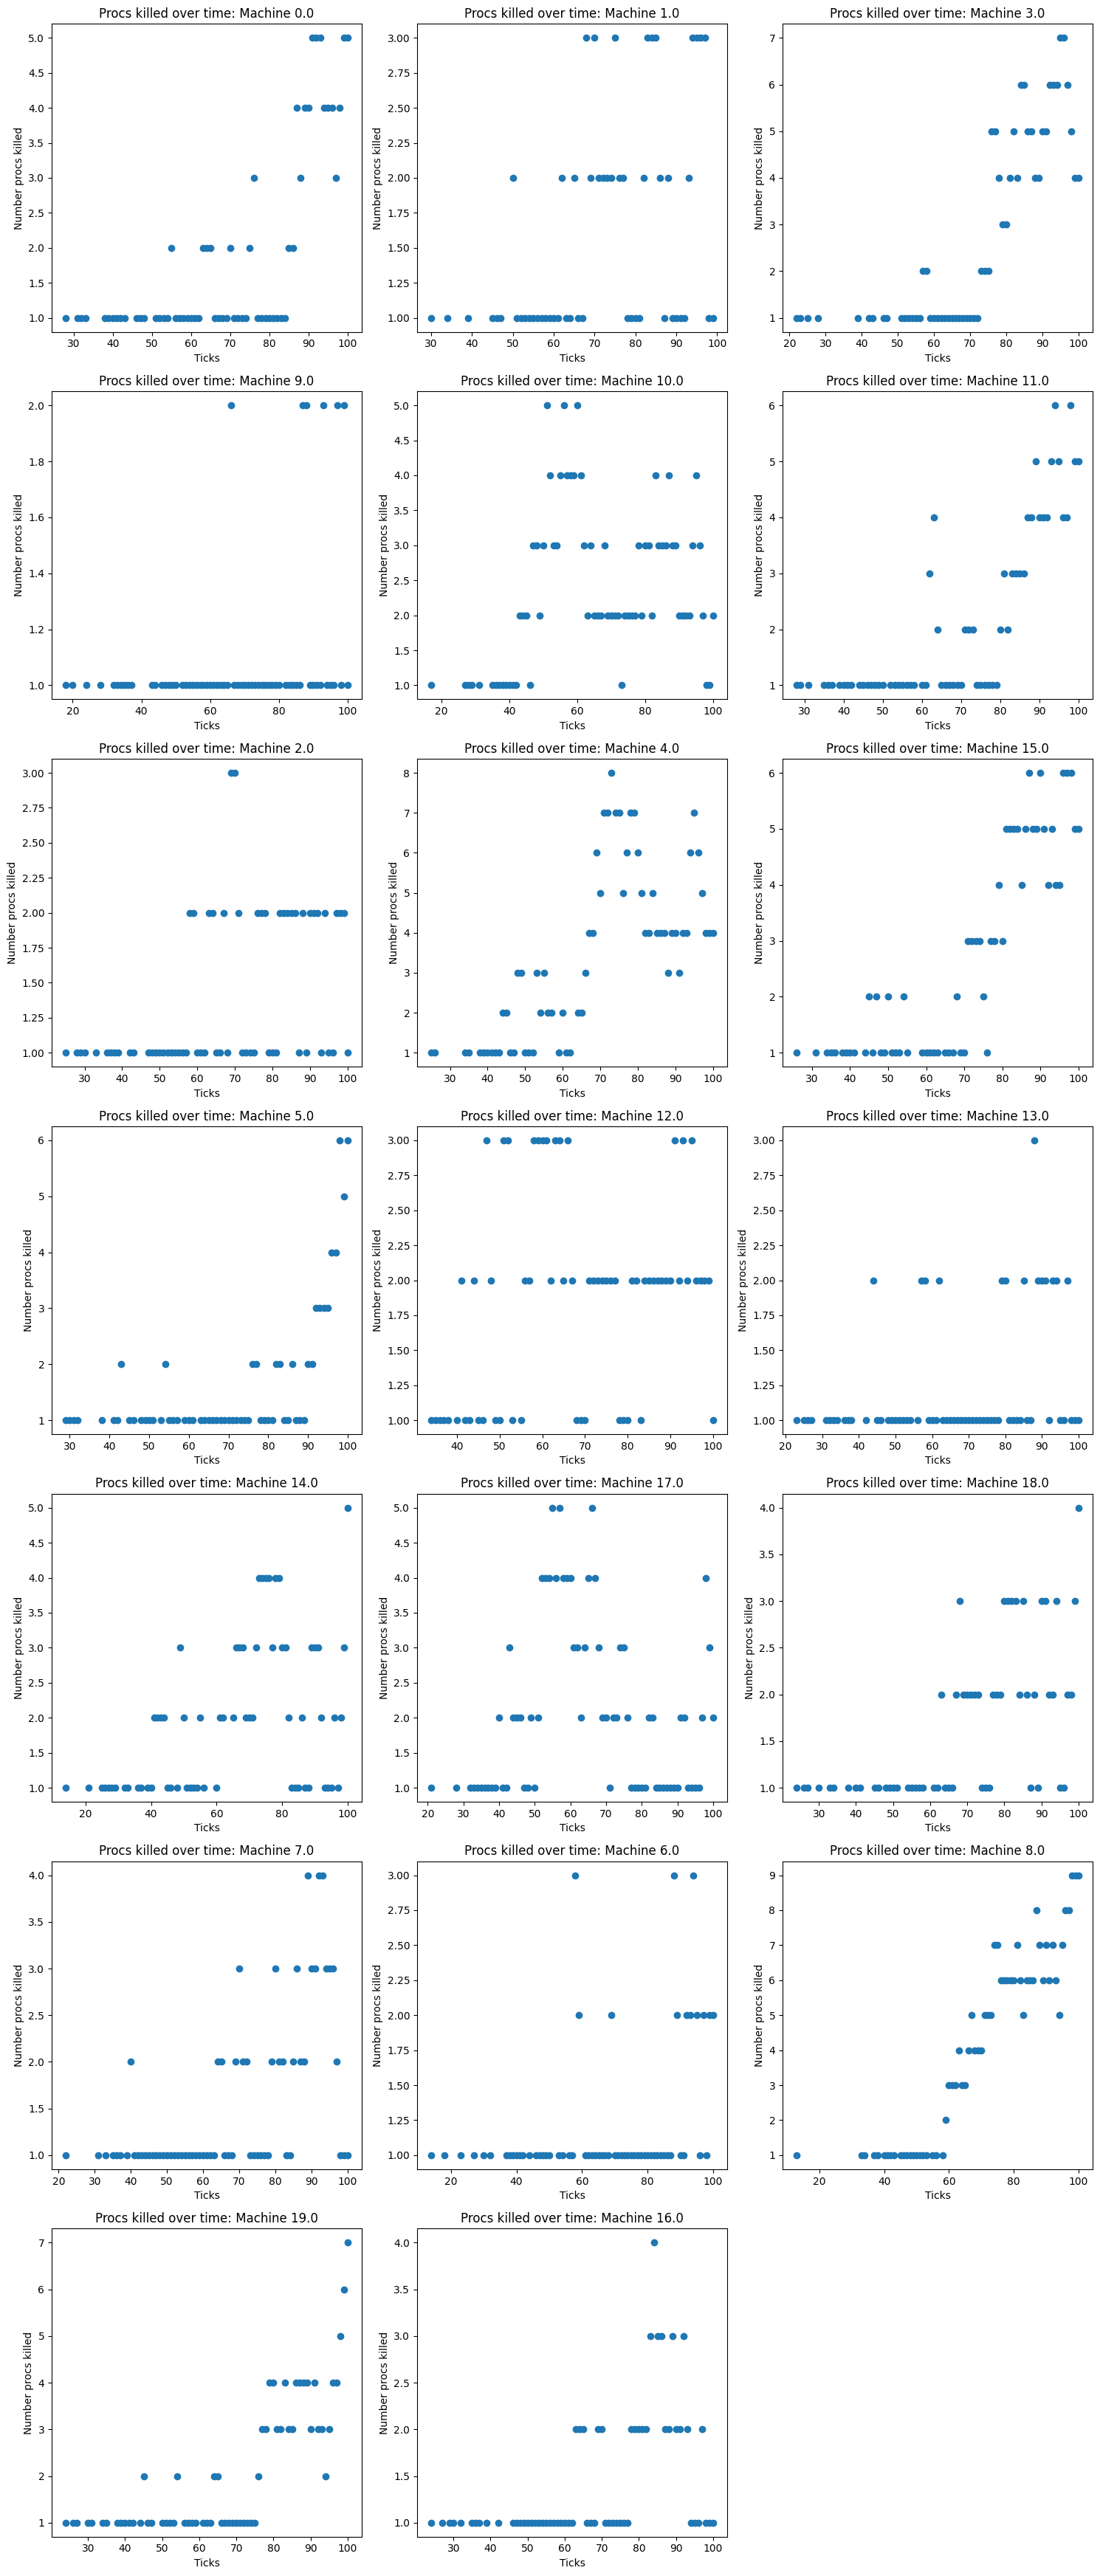

In [33]:
unique_ids = procs_late['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]

    procs_killed_here = procs_killed.where((procs_killed['machineID']==id_)).dropna().reset_index(drop=True)
    ticks_procs_killed_here = procs_killed_here[["tick"]].groupby("tick").size().reset_index(name='counts')

    ax.scatter(ticks_procs_killed_here["tick"], ticks_procs_killed_here['counts'].values)
    ax.set_title(f'Procs killed over time: Machine {id_}')
    ax.set_xlabel('Ticks')
    ax.set_ylabel('Number procs killed')
    # ax.set_grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# To understand LB decisions

## Procs being added

In [376]:
tick = 50

# like from SCHEDULER_SLA_HISTOGRAM_BASE in world.go
BASE = 2


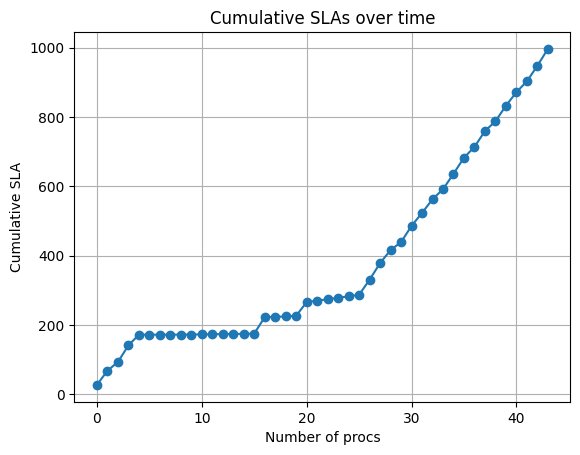

In [377]:
# CDF of all procs added (NOTE this includes all procs that are being recycled because they were killed)

cdf = procs_added.where((procs_added['tick']==tick))[['sla', 'machineID']].dropna().sort_index().reset_index(drop=True).cumsum()
# cdf["machineID"] = np.where(cdf["machineID"] == machine, True, False)
# cdf = tick_vals.sort_index()

# machine_procs = cdf[cdf['machineID'] == True]
# other_procs = cdf[cdf['machineID'] == False]

plt.plot(cdf.index, cdf['sla'].values, marker='o', linestyle='-')
# plt.plot(other_procs.index, other_procs['sla'].values, 'bo', label='False')
# plt.plot(machine_procs.index, machine_procs['sla'].values, 'ro', label='True')
plt.xlabel('Number of procs')
plt.ylabel('Cumulative SLA')
plt.title('Cumulative SLAs over time')
plt.grid(True)
# plt.legend()
plt.show()

array([[<Axes: title={'center': 'sla'}>]], dtype=object)

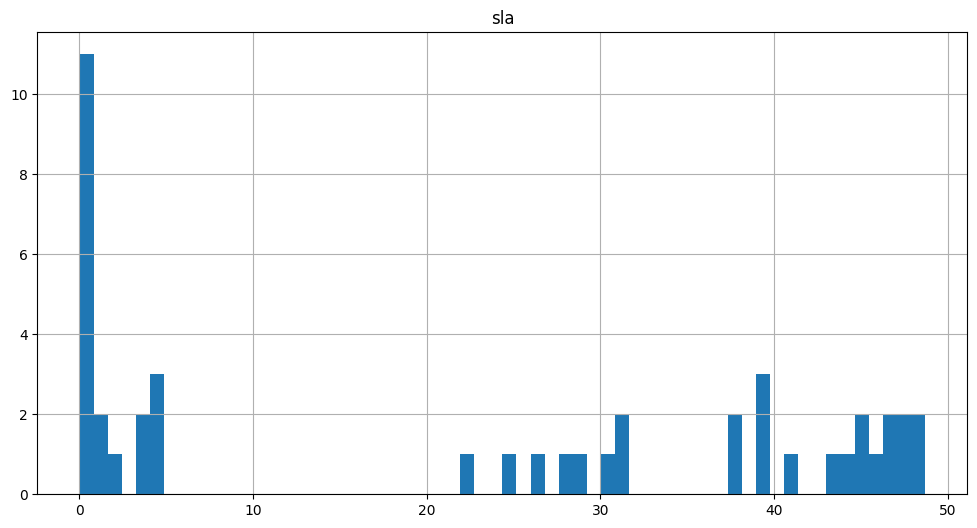

In [425]:
slas = procs_added.where((procs_added['tick']==tick)).dropna()
slas[['sla']].hist(bins=60, figsize=(12,6))


# shows buckets that I use in the code
# base_vals = pd.DataFrame()
# base_vals['base'] = np.power(BASE, np.floor(np.log(slas['sla'])/np.log(BASE))).reset_index(drop=True)

# counts = base_vals.groupby('base').size().reset_index(name='counts')
# counts
# counts.plot.bar(x='base', y='counts', color='skyblue', edgecolor='black')


## Where they're being added to

### Overview of machines existing states

In [390]:
procs_tick_current = procs_current.where((procs_current['tick']==tick))[['machineID', 'sla', 'compDone']].dropna().sort_values('machineID')
procs_tick_current['diffToSla'] = procs_tick_current['sla'] - procs_tick_current['compDone']

print(procs_tick_current)

      machineID        sla  compDone  diffToSla
5698        0.0  36.496076  0.000440  36.495636
5699        0.0   4.732312  0.915681   3.816631
5700        0.0   4.384183  3.118573   1.265610
5701        0.0   4.324185  1.219692   3.104493
5702        0.0   3.166388  0.000000   3.166388
...         ...        ...       ...        ...
5917       19.0   4.778033  0.543484   4.234549
5916       19.0   5.419571  2.036145   3.383426
5925       19.0   0.525758  0.100781   0.424977
5920       19.0   3.263912  0.209569   3.054343
5926       19.0   0.288107  0.000000   0.288107

[229 rows x 4 columns]


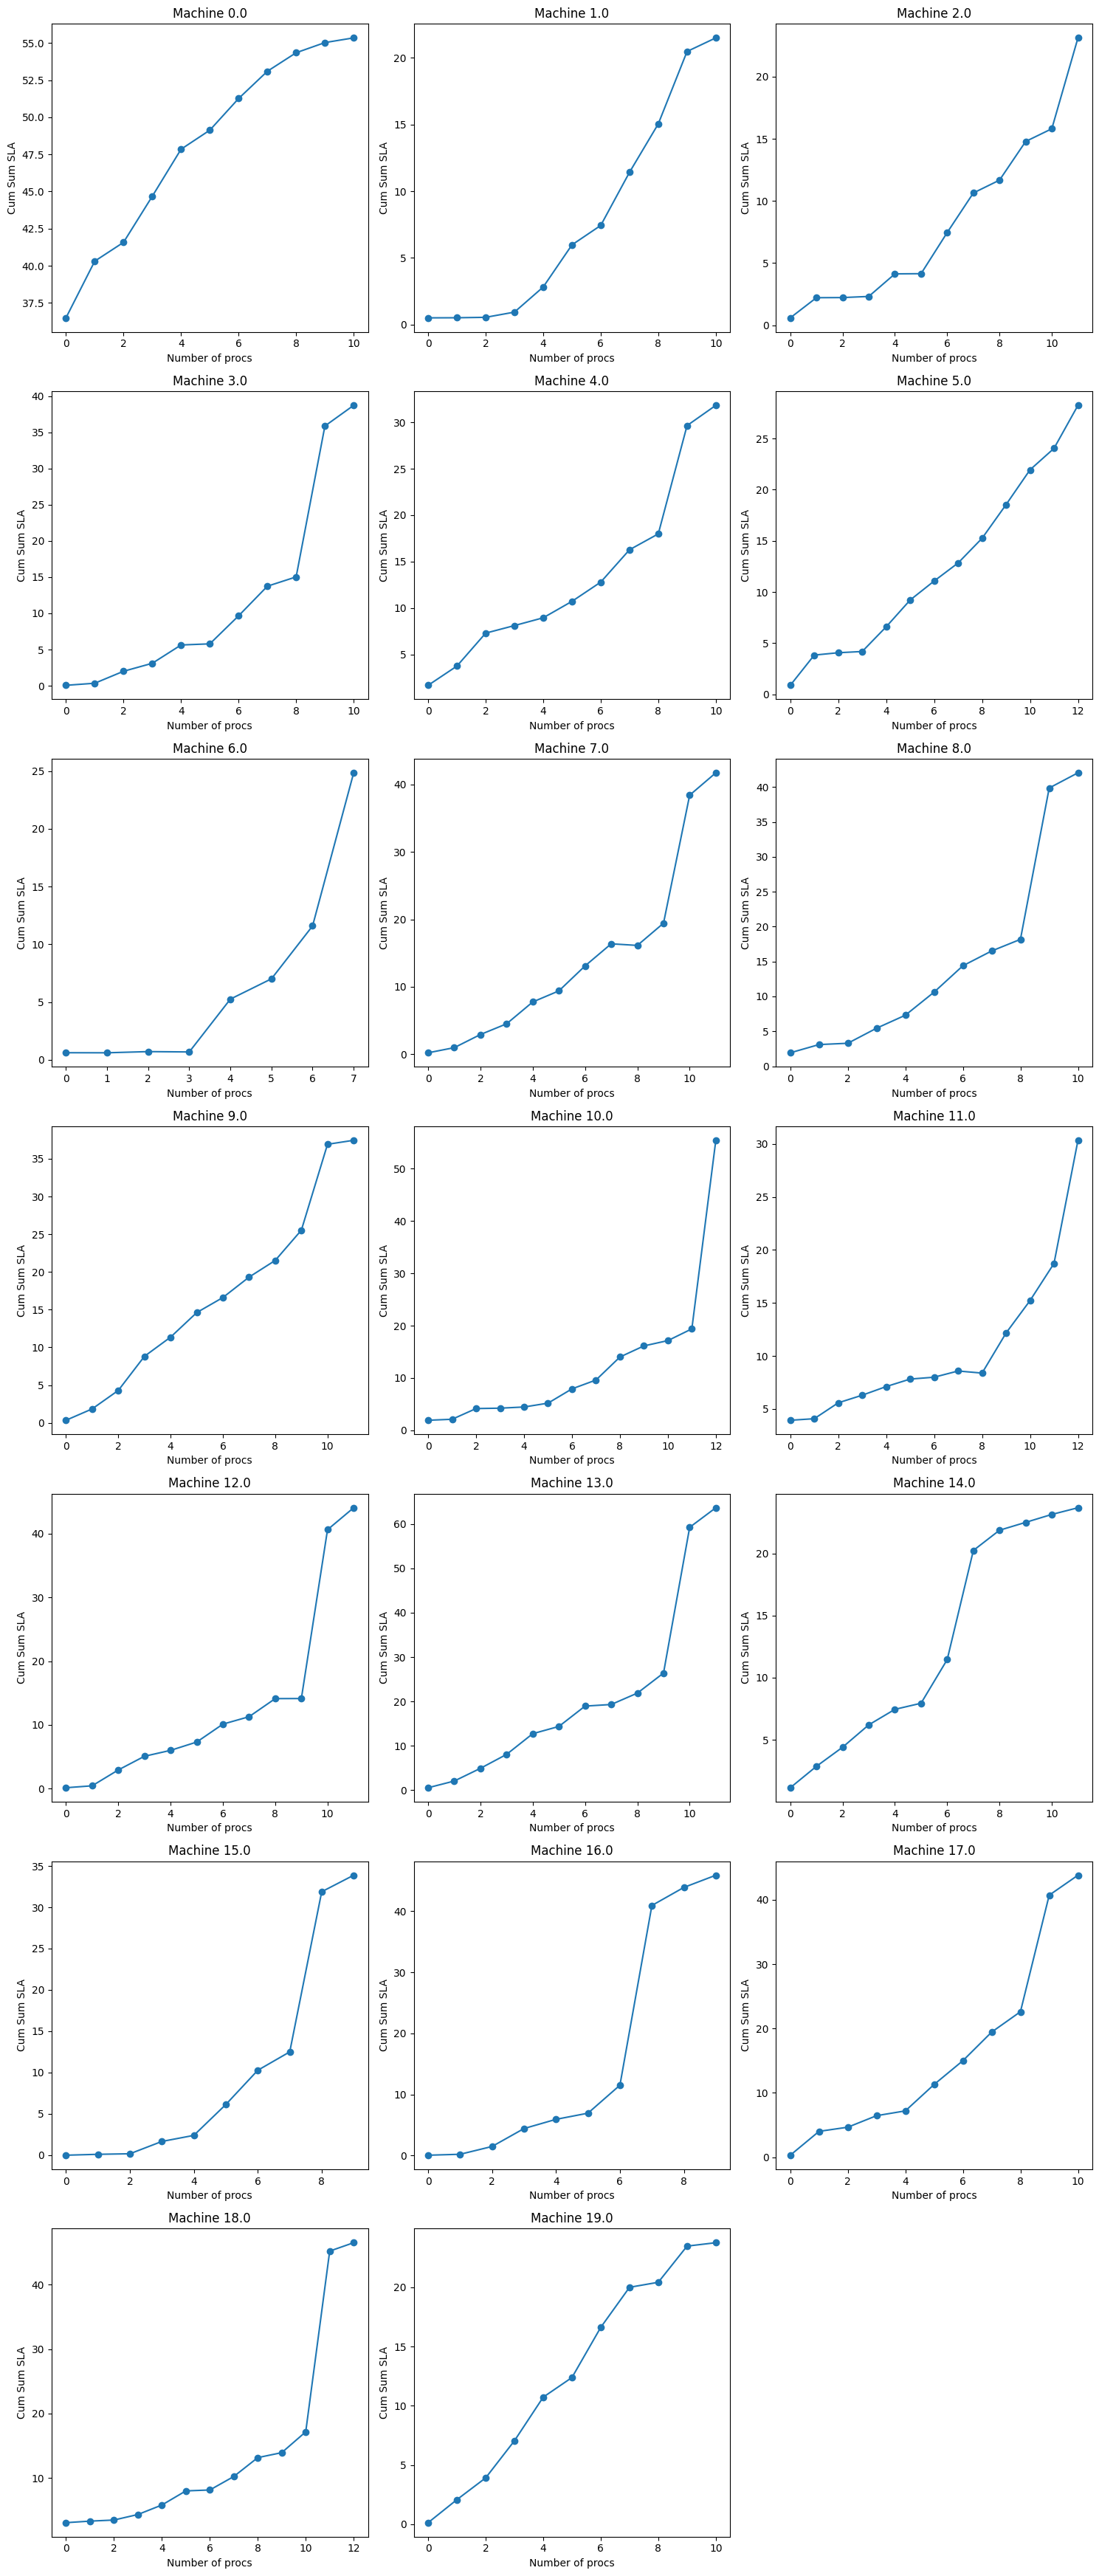

In [413]:
# CDFs of all the procs currently on each machine (looking at diffToSLA)
unique_ids = procs_tick_current['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    data = procs_tick_current.where((procs_tick_current['machineID']==id_))["diffToSla"].dropna().reset_index(drop=True)
    ax.plot(data.index, data.cumsum().values, marker='o', linestyle='-')
    ax.set_title(f'Machine {id_}')
    ax.set_xlabel('Number of procs')
    ax.set_ylabel('Cum Sum SLA')

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

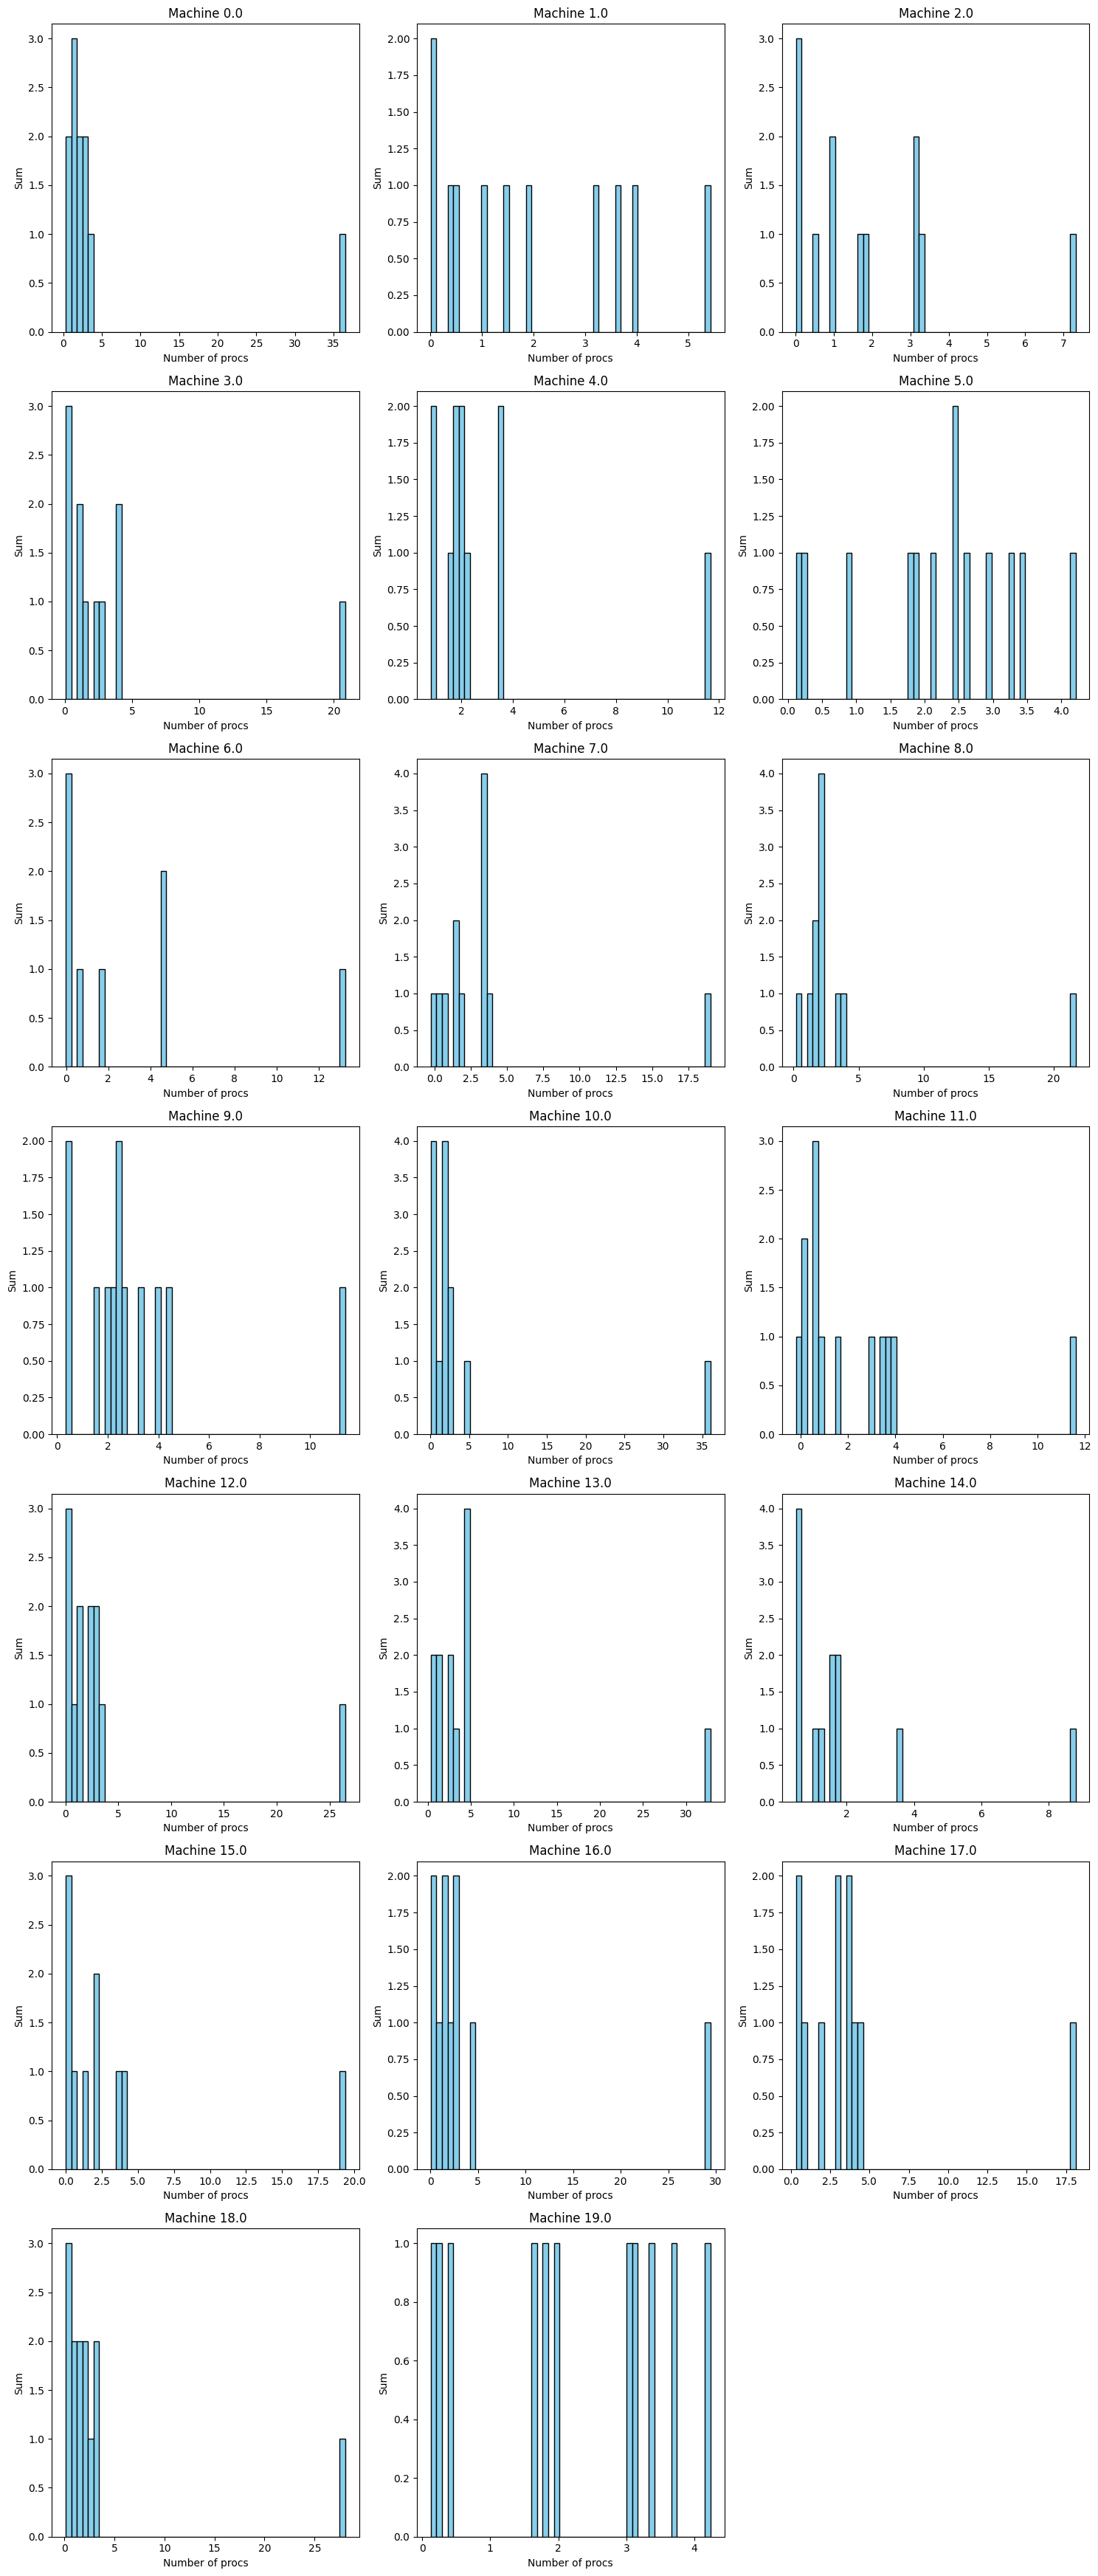

In [394]:
# histogram of all the procs currenlty on each machine -- and the ones being added

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each id's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    curr_procs = procs_tick_current.where((procs_tick_current['machineID']==id_)).dropna()
    # this is for if we want to use the buckets that I use in the code to determine where to put procs
    # base_vals = pd.DataFrame()
    # base_vals['base'] = np.power(2, np.floor(np.log(slas['sla'])/np.log(2))).reset_index(drop=True)
    
    ax.hist(curr_procs['diffToSla'], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Machine {id_}')
    ax.set_xlabel('Diff to SLA')
    ax.set_ylabel('Number of Procs')

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Machines the new procs were added to

In [412]:
# look at state after new procs: where ae they being added
procs_tick_added = procs_added.where((procs_added['tick']==tick))[['machineID', 'sla']].dropna().reset_index(drop=True)
procs_tick_added = procs_tick_added.rename(columns={"sla":"diffToSla", "machineID": "machineID"})
# total_procs = procs_tick_current[['machineID', 'diffToSla', 'compDone']].append(procs_tick_added)
total_procs = pd.concat([procs_tick_current[['machineID', 'diffToSla', 'compDone']], procs_tick_added])
total_procs['isNew'] = total_procs['compDone'].isna()
total_procs = total_procs.drop('compDone', axis=1)


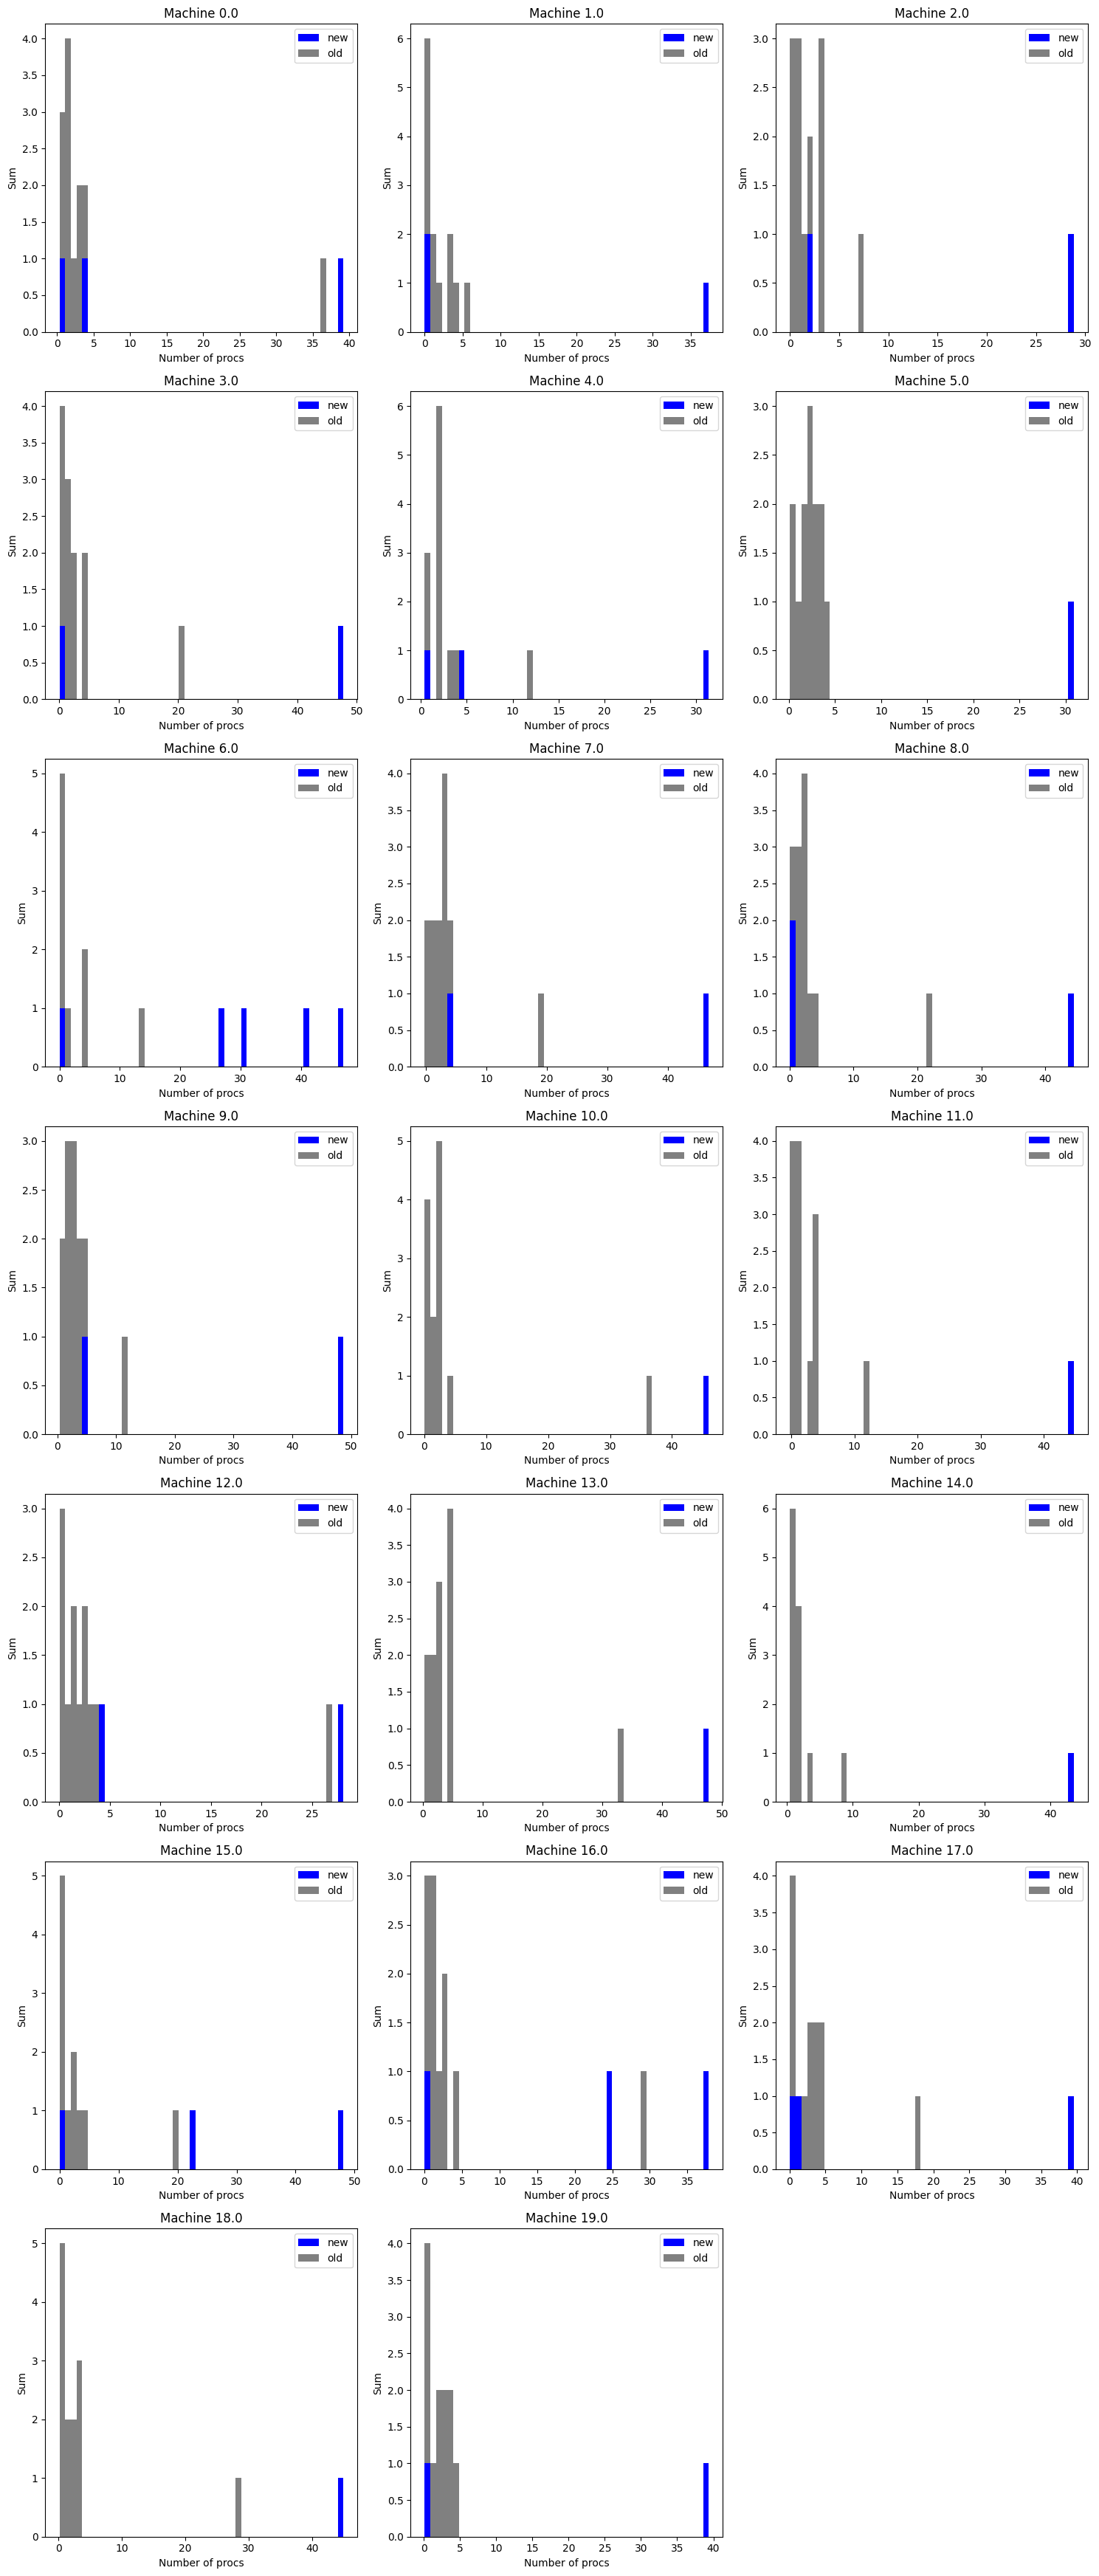

In [448]:
# CDFs of all the procs currently on each machine (looking at diffToSLA)
unique_ids = total_procs['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    all_procs = total_procs.where((total_procs['machineID']==id_)).dropna().reset_index(drop=True)

    new_data = all_procs.where((all_procs['isNew']==True)).dropna().reset_index(drop=True)
    old_data = all_procs.where((all_procs['isNew']==False)).dropna().reset_index(drop=True)

    # Plotting
    ax.hist([new_data["diffToSla"], old_data["diffToSla"]],
            bins=50, stacked=True,
            color=['blue', 'gray'],
            label=['new', 'old'])

    ax.set_title(f'Machine {id_}')
    ax.set_xlabel('Number of procs')
    ax.set_ylabel('Sum')
    ax.legend(prop={'size': 10})

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# To understand Core Scheduler Decisions